# UNET - Train on Fashion Dataset


This notebook shows how to train UNET on the Fashion dataset.

### The Dataset Object
This notebook will implement a Dataset object from the mcrnn implementation.  The dataset object holds a listing of all relevant data needed for training images and respective masks.  The object holds file references to the images and encoded masks for semantic segmentation.

The same dataset object used for training the MRCNN implementation is used in this workbook.  This helps to compare numerous implementation results by ensureing the same training data is used.

### UNET
UNET is a model that will produce a semantic segmentation based on an input image.  UNET acts as an encoder by using CNN's and Max Pooling to create an encoder and uses Upscaling and CNN's to decode.  UNET will output a sementaic segmentation of the same dimension as the input.  Each channel of the output is a binary mask for a segmentation class.  UNET's key feature is that the final output from each layer is concatenated with the corresponding layer on the decoding side.  The key feature allows the decoder to better represent more complex shape in the segmentation.  

### Limitations
#### Semantic Segmentation Only
UNET in its basic form will only output a semantic segmenation.  No boxing or instance identification is included.  This will increase the speed of training, but limits it use.

#### Fixed Dimensions
A UNET model is compiled with a fixed input dimension which drives a fixed output dimension.  Any training images or inferrence images will need to have the specificed input dimension.  MRCNN is more flexible and allows an input image of any size.


## Unet Architecture
![title](Unet_architecture.png)

### Setup local variables

In [6]:
import os, sys

project_root = "/Users/markmcdonald/Library/Mobile Documents/com~apple~CloudDocs/Harvard/CSCI_E25/Project/computer-vision-project"
data_dir     = '../../data/FashionDataSet/'
train_dir    = os.path.join(data_dir, 'train')
images_file  = os.path.join(data_dir, 'train.csv' )
cat_file     = os.path.join(data_dir, 'label_descriptions.json' )
sys.path.append(project_root)
os.path.isdir(data_dir), os.path.isdir(train_dir), os.path.isfile(images_file), os.path.isfile(images_file)

(True, True, True, True)

## Set Backend For GPU Support
This can be commented out if an Nvidia GPU is being used or if processing is to be done using local CPUs

In [7]:
import os
# fix libiomp5.dylib error for mac
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# OPTIONAL SETTING
# Here we override the keras backend env variable to use plaidml
# plaidml can make use of AMD GPUs 
# This assignment needs to be added before loading keras libraries

# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# to install plaidML, activate appropriate environment and then:
#   pip install -U plaidml-keras
#   plaidml-setup


### Load Modules

In [8]:
import warnings
warnings.filterwarnings('ignore')

import datetime, os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import skimage
import random
from sklearn.model_selection import train_test_split
import pickle


from FashionUtils import FashionDataset
# from FashionDataset import load

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")



# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


from mrcnn.visualize import display_images

%matplotlib inline 

Using TensorFlow backend.


In [9]:
# Keras imports
if os.environ.get("KERAS_BACKEND") == "plaidml.keras.backend":
    print("Loading Plaid libraries for Keras.")
    import keras
    
    from keras.models import Model, load_model, model_from_json
    from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
    from keras.layers.core import Lambda, RepeatVector, Reshape
    from keras.layers.convolutional import Conv2D, Conv2DTranspose
    from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
    from keras.layers.merge import concatenate, add
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
    from keras.optimizers import Adam, SGD
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from keras.utils import to_categorical
    from keras.layers import UpSampling2D
    from keras.preprocessing import image
    from keras.applications.resnet_v2 import ResNet152V2

else:
    print("Loading Tensorflow libraries for Keras.")
    import tensorflow as tf

    from tensorflow.python.keras.models import Model, load_model, model_from_json
    from tensorflow.python.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
    from tensorflow.python.keras.layers.core import Lambda, RepeatVector, Reshape
    from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
    from tensorflow.python.keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
    from tensorflow.python.keras.layers.merge import concatenate, add
    from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    from tensorflow.python.keras.optimizers import Adam, SGD
    from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from tensorflow.python.keras.utils import to_categorical
    from tensorflow.python.keras.layers import UpSampling2D
    from tensorflow.python.keras.preprocessing import image
    from tensorflow.python.keras.applications.resnet_v2 import ResNet152V2
    

Loading Tensorflow libraries for Keras.


In [10]:
# !pip install ipywidgets 
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager




### Define Dataset Object
from the mask rcnn implementation

In [11]:
class FashionDataset(utils.Dataset):
    """
    Implements mrcnn.utils.Dataset.
    FashionDataset holds data relevant to the imaterialist challenge data.  
    """

    def __init__(self):
        super(FashionDataset, self).__init__()  
        self.class_names= []

    @staticmethod
    def load(filepath:str):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            return data

    def save(self, filepath:str):
        with open(save_file, 'wb') as f:
            pickle.dump(self, filepath)

    def create_classes(self, cat_file:str) -> [dict]:
        """
        Added to FashionDataset.
        Initialize the classes.
        param:cat_file - filepath to fashion dataset's label_descriptions.json file
        """
        # read labels file
        with open(cat_file, 'r') as data_file:
            data=data_file.read()

        # parse file
        labels = json.loads(data)

        categories = labels.get('categories')
        df_categories = pd.DataFrame(categories)
        df_categories['source'] = "imaterialist"

        dict_categories = [dict(x[1]) for x in df_categories.iterrows()]

        for c in dict_categories:
            self.add_class(c['source'], c['id']+1, c['name']) # add 1 to make room for background

        print ("{} classes added.".format(len(dict_categories)))

        return dict_categories


    def create_anns(self, sub_df_images:pd.DataFrame) -> dict:
        """
        Creates an 'annotations' entry in an image's image_info entry.
        dict_keys(['id', 'image_id', 'segmentation', 'category_id', 'area', 'iscrowd', 'bbox']
        """
        annotations = []

        for mask in sub_df_images.iterrows():
            h      = int(mask[1].get('height'))
            w      = int(mask[1].get('width'))
            counts = np.fromstring(mask[1]['EncodedPixels'], dtype=int, sep=" ")
            ann_dict = {'id'            : mask[1]['id'] , 
                        'image_id'      : mask[1]['file_name'] , 
                        'segmentation'  : {'counts' : counts, 'size': [h, w] }, 
                        'category_id'   : int(mask[1]['ClassId'].split('_')[0])+1, # add 1 to make room for background
                        'iscrowd'       : True, # True indicates the use of uncompressed RLE
                        'bbox'          : [] }

            annotations.append(ann_dict)

        return annotations


    def create_images(self, images_file:str, train_dir:str, imgids:list=None, limit:int=None) -> (dict, pd.DataFrame):
        """
        Build the image_info['images'] dictionary element with all images.
        If imgids list is None, all images in the images_file will be included, otherwise,
        only the imgids in the list will be included.
        """

        df_images = pd.read_csv(images_file, nrows=limit)

        # restrict the dataframe to items in imgids list, if list is provided
        if imgids is not None:
            df_images = df_images[df_images.ImageId.isin(imgids)]

        df_images.rename(columns={"ImageId":'file_name', "Height":'height', "Width":'width'}, inplace=True)
        df_images['id'] = [x for x in range(len(df_images))]
        df_images['source'] = 'imaterialist'

        dict_images = [dict(x[1]) for x in tqdm(df_images.iterrows(), desc="Create images dict", total=len(df_images))]

        for image in tqdm(dict_images, desc="Add images to object"):
            file_path = os.path.join(train_dir,image['file_name'])
            self.add_image(source       = image['source'], 
                           image_id     = image['id'],
                           path         = file_path, 
                           height       = image['height'],
                           width        = image['width'],
                           file_name    = image['file_name'],
                           annotations  = self.create_anns(df_images[df_images.file_name==image['file_name']]))

        print("Added {} images.".format(len(df_images)))

        return self.image_info


    def load_image(self, image_id):
        """
        Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image


    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """

        image_info = self.image_info[image_id]

        instance_masks = []
        class_ids = []

        # returns list of masks/annotations for the image
        annotations = self.image_info[image_id]["annotations"] 

        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id'] # one of 46 categories

            if class_id:
                # updated to reflect problems with original maskutils implementtaion of decode
                m = self.kaggle_rle_decode(annotation, image_info["height"], image_info["width"])

                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids


    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.
        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        # assume user provided the integer id of the image
        for img in self.image_info:
            if img['id'] == image_id:
                return img['path']

        # check if the user entered the file name
        for img in self.image_info:
            if img['file_name'] == image_id:
                return img['path']

        print ("Image '{}' not found.".format(image_id))
        return None


    def kaggle_rle_decode(self, ann, h, w):
        """
        https://github.com/amirassov/kaggle-imaterialist/blob/master/src/rle.py
        Takes uncompressed RLE for a single mask.  Returns binary mask.
        param: ann - annotation including uncompressed rle in ['segmentation']['counts'] 
        -- where counts is a list of integers.  Also includes 'size' which is a list [int(h), int(w)] 
        """
        rle = ann['segmentation']['counts']

        starts, lengths = map(np.asarray, (rle[::2], rle[1::2]))
        starts -= 1
        ends = starts + lengths
        img = np.zeros(h * w, dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape((w, h)).T

In [24]:
def create_train_val_datasets(images_file:str, 
                              cat_file:str, 
                              split:float=0.8, 
                              limit:int=None) -> (FashionDataset,FashionDataset):
    """
    Returns a train and a val dataset object.
    If limit is None, all entries in file will be used as the population.
    """
    # split the train.csv file into train and val dataframes
    df_images = pd.read_csv(images_file, nrows=limit)
    
    # OPTN1: split so that some images will have some annotations in train and others in val
#     df_train, df_val = train_test_split(df_images , train_size=split)
    
    # OPTN2: split to that images' annotations are not in defferent sets
    image_filenames = np.unique(df_images.ImageId)
    train_imgids, val_imgids = train_test_split(image_filenames , train_size=.8)
    
    # Create empty objects
    fash_train = FashionDataset()
    fash_val = FashionDataset()
    
    # build classes in dataset objects
    train_classes = fash_train.create_classes(cat_file) # takes seconds
    val_classes   = fash_val.create_classes(cat_file)   # takes seconds
    
    # load image references and masks into dataset objects
    print("Building trainig dataset...")
    train_image_info = fash_train.create_images( images_file, train_dir, train_imgids, limit=limit) 
    print("Building validation dataset...")
    val_image_info   = fash_val.create_images(   images_file, train_dir, val_imgids,   limit=limit) 
    
    fash_train.prepare()
    fash_val.prepare()
    
    return fash_train, fash_val

### Load FasionDataset Objects
If you have saved the datasets, you can load them, it resplit and build them again.

In [19]:
# import pickle

# Use pickle to save history for later use
def pickle_save(variable, save_dir, pickel_fileName):
    save_file = os.path.join(save_dir, pickel_fileName)
    if os.path.isdir(save_dir) == 0:
        os.mkdir(save_dir)
    with open(save_file, 'wb') as f:
        pickle.dump(variable, f)


# Loading a prevously saved pickle file
def pickle_load(save_dir, pickel_fileName):
    # Getting back the data:
    pickle_filepath = os.path.join(save_dir, pickel_fileName)
    with open(pickle_filepath, 'rb') as f:
        data = pickle.load(f)
        return data

In [25]:
# NOTE: There are 300k line images in the full training list
# fash_train, fash_val = create_train_val_datasets( images_file, 
#                                                   cat_file, 
#                                                   split=0.9, 
#                                                   limit=20000)

# pickle_save(fash_train, data_dir, 'fashion_train_dataset_20k.pkl')
# pickle_save(fash_val, data_dir, 'fashion_val_dataset_20k.pkl')

In [26]:
fash_train = pickle_load(data_dir, 'fashion_train_dataset_10k.pkl')
fash_val = pickle_load(data_dir, 'fashion_val_dataset_10k.pkl')


In [29]:
im_height = 128
im_width = 128
im_channels = 3
im_shape = (im_height, im_width, im_channels)
n_classes = len(fash_train.class_ids)

In [30]:
# U-Net architecture
def UNet(input_img):

    # Contracting Path
    enc1 = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
    enc1 = Conv2D(64, (3,3), activation='relu', padding='same')(enc1)
    
    enc2 = MaxPooling2D(pool_size=(2,2))(enc1)
    enc2 = Conv2D(128, (3,3), activation='relu', padding='same')(enc2)
    enc2 = Conv2D(128, (3,3), activation='relu', padding='same')(enc2)
    
    enc3 = MaxPooling2D(pool_size=(2,2))(enc2)
    enc3 = Conv2D(256, (3,3), activation='relu', padding='same')(enc3)
    enc3 = Conv2D(256, (3,3), activation='relu', padding='same')(enc3)
    
    enc4 = MaxPooling2D(pool_size=(2,2))(enc3)
    enc4 = Conv2D(512, (3,3), activation='relu', padding='same')(enc4)
    enc4 = Conv2D(512, (3,3), activation='relu', padding='same')(enc4)
    
    encoder = MaxPooling2D(pool_size=(2,2))(enc4)
    encoder = Conv2D(1024, (3,3), activation='relu', padding='same')(encoder)
    encoder = Conv2D(1024, (3,3), activation='relu', padding='same')(encoder)
    
    # Expansive Path
    dec4 = UpSampling2D((2,2))(encoder)
    dec4 = concatenate([dec4,enc4])
    dec4 = Conv2D(512, (3,3), activation='relu', padding='same')(dec4)
    dec4 = Conv2D(512, (3,3), activation='relu', padding='same')(dec4)
    
    dec3 = UpSampling2D((2,2))(dec4)
    dec3 = concatenate([dec3,enc3])
    dec3 = Conv2D(256, (3,3), activation='relu', padding='same')(dec3)
    dec3 = Conv2D(256, (3,3), activation='relu', padding='same')(dec3)
    
    dec2 = UpSampling2D((2,2))(dec3)
    dec2 = concatenate([dec2,enc2])
    dec2 = Conv2D(128, (3,3), activation='relu', padding='same')(dec2)
    dec2 = Conv2D(128, (3,3), activation='relu', padding='same')(dec2)
    
    dec1 = UpSampling2D((2,2))(dec2)
    dec1 = concatenate([dec1,enc1])
    dec1 = Conv2D(64, (3,3), activation='relu', padding='same')(dec1)
    
    # c_exp = final feature maps from expansive path
    c_exp = Conv2D(64, (3,3), activation='relu', padding='same')(dec1)
    
    # output layer must change
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c_exp)
    print("outputs shape: ", outputs.shape)
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

### Generators for Images and Masks

In [31]:
class ImgMask_sequencer(keras.utils.Sequence):
    """
    Create batch generator based on Dataset object.
    Returns images and masks resize to target_size provided.
    """

    def __init__(self, dataset, batch_size:int=32, name:str=None, target_size:tuple=(im_height,im_width)):

        self.dataset      = dataset
        self.batch_size   = batch_size
        self.length       = len(self.dataset.image_info)
        self.num_batches  = int(self.length / self.batch_size)+1
        self.name         = name
        self.target_size  = target_size
        self.classes      = self.dataset.source_class_ids['imaterialist']
        self.num_classes  = len(self.classes)

        print("Creating Generator '{}':".format(self.name))
        print("\tbatch size : ", self.batch_size)
        print("\tlength     : ", self.length)
        print("\tnum batches: ", self.num_batches)
        print("\ttarget size: ", self.target_size)
        
    def __len__(self):
        return self.num_batches
    
    def __getitem__(self, idx):

        img_ids    = self.dataset.image_ids
       
        # get batch_num number of entries from dataset
        images, masks = [], []
        start = self.batch_size * idx
        end   = self.batch_size * (idx+1)

        for i in img_ids[start:end]:
            # load image and resize
            img  = self.dataset.load_image(i)
            img  = np.resize(img, (self.target_size[0], self.target_size[1], 3))
#             img, window, scale, padding, crop  = utils.resize_image(img, max_dim=self.target_size[0], mode='square')

            # load mask and resize
            mask, mask_classes = self.dataset.load_mask(i)
            mask  = np.resize(mask, (self.target_size[0], self.target_size[1], 3))
#             mask = utils.resize_mask(mask, scale, padding, crop)
            
            # create stacked mask
            stacked_mask = np.zeros(shape=(im_shape[0], im_shape[1], self.num_classes))
            for i, msk_class in enumerate(mask_classes):
                stacked_mask[:,:,msk_class] = mask[:,:,i]

            images.append(img/255)
            masks.append(stacked_mask)

        return np.stack(images, axis=0), np.stack(masks, axis=0)


### Defin UNET model Structure

In [32]:


model = UNet(Input(im_shape, name='img'))

model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_rx_vega_64.0"


outputs shape:  Shape(dtype=<DType.FLOAT32: 50>, dims=(<tile.Value Operation UINT64()>, 128, 128, 47))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_2[0][0]                   
______

### Train Model

In [33]:
# add tensorboard to notebook
%load_ext tensorboard

logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [34]:
# Train Model
batch_size=128

# Setup callbacks
logdir=os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(os.path.join(logdir,'model-unet-fashion.h5'), verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=0, batch_size=batch_size, update_freq='batch')
]

img_dir = os.path.join(data_dir, 'train', 'train_images', 'images')
mask_dir = os.path.join(data_dir, 'train', 'train_masks', 'masks')

len_train = len(fash_train.image_info)
len_val   = len(fash_val.image_info)

# Get generators for training and validation
train_gen  = ImgMask_sequencer(  fash_train, 
                                 batch_size=batch_size,
                                 name="Train Generator",
                                 target_size=(im_height,im_width))

val_gen   = ImgMask_sequencer(   fash_val, 
                                 batch_size=batch_size,
                                 name="Val Generator",
                                 target_size=(im_height,im_width))

optimizer = SGD(lr=.002,momentum=.9)
#optimizer = Adam(lr=.005)
model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

results = model.fit_generator(  train_gen,  
                                epochs=8,
                                callbacks=callbacks, 
                                validation_data=val_gen) #,
#                                 use_multiprocessing=True, workers=4)

Creating Generator 'Train Generator':
	batch size :  128
	length     :  8032
	num batches:  63
	target size:  (128, 128)
Creating Generator 'Val Generator':
	batch size :  128
	length     :  1968
	num batches:  16
	target size:  (128, 128)


Epoch 1/5


INFO:plaidml:Analyzing Ops: 210 of 426 operations complete


 1/63 [..............................] - ETA: 1:10:33 - loss: 0.5286 - acc: 7.1192e-04WARNING:tensorflow:From /anaconda3/envs/cs25/lib/python3.6/site-packages/keras/callbacks/tensorboard_v1.py:343: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.

30/63 [=============>................] - ETA: 34:37 - loss: 0.6008 - acc: 0.0086

INFO:plaidml:Analyzing Ops: 210 of 426 operations complete


63/63 [==============================] - 3964s 63s/step - loss: 0.5979 - acc: 0.0164 - val_loss: 0.6356 - val_acc: 0.0350

Epoch 00001: val_loss improved from inf to 0.63563, saving model to ./logs/20191130-173356/model-unet-fashion.h5
Epoch 2/5
63/63 [==============================] - 3585s 57s/step - loss: 0.5903 - acc: 0.0257 - val_loss: 0.6245 - val_acc: 0.0351

Epoch 00002: val_loss improved from 0.63563 to 0.62452, saving model to ./logs/20191130-173356/model-unet-fashion.h5
Epoch 3/5
63/63 [==============================] - 3649s 58s/step - loss: 0.5763 - acc: 0.0257 - val_loss: 0.5995 - val_acc: 0.0351

Epoch 00003: val_loss improved from 0.62452 to 0.59953, saving model to ./logs/20191130-173356/model-unet-fashion.h5
Epoch 4/5
63/63 [==============================] - 3633s 58s/step - loss: 0.5346 - acc: 0.0257 - val_loss: 0.5221 - val_acc: 0.0351

Epoch 00004: val_loss improved from 0.59953 to 0.52210, saving model to ./logs/20191130-173356/model-unet-fashion.h5
Epoch 5/5
63/6

After training tasks:
> change batch size to 64

> consider using Adam again (didn't help)

> consider increasing im size to 256

> change the resizeing strategy to avoid bars - retrain with SGD .001



In [35]:
model.save('model-unet-fashion-5epochs1.h5')

In [53]:
# optimizer = Adam(lr=.005) # This made the loss increase - acc stayed the same
optimizer = SGD(lr=.1,momentum=.9) # increase LR to break out of local minimum
model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

results = model.fit_generator(  train_gen,  
                                epochs=5,
                                callbacks=callbacks, 
                                validation_data=val_gen,
                                use_multiprocessing=True, workers=4)

Epoch 1/5
63/63 [==============================] - 4160s 66s/step - loss: 2.0734 - acc: 0.0257 - val_loss: 2.0630 - val_acc: 0.0351

Epoch 00001: val_loss did not improve from 0.48116
Epoch 2/5
63/63 [==============================] - 3942s 63s/step - loss: 2.0734 - acc: 0.0257 - val_loss: 2.0630 - val_acc: 0.0351

Epoch 00002: val_loss did not improve from 0.48116
Epoch 3/5
63/63 [==============================] - 3923s 62s/step - loss: 2.0734 - acc: 0.0257 - val_loss: 2.0630 - val_acc: 0.0351

Epoch 00003: val_loss did not improve from 0.48116
Epoch 4/5
63/63 [==============================] - 3900s 62s/step - loss: 2.0734 - acc: 0.0257 - val_loss: 2.0630 - val_acc: 0.0351

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00004: val_loss did not improve from 0.48116
Epoch 00004: early stopping


In [37]:
model.save('model-unet-fashion-8epochs2.h5')

### RESNET152V2
Using pre-trained weights to improve trainin speed.

Here, we use pre-trained RESNET weights to start the model.  We will only import the top of the network and add new layers at the bottom to reflect our desired output.

The strategy is to used the pretrained RESNET as the encoder and then train a UNET decoder.  We will use RESNET as the base and add the UNET decoder layers, then freeze the RESNET encoder and train the model.



In [76]:

def UNet_Resnet(encoder, target_shape:tuple=(256,256,3)):

    

    # add layers on top of the base model
    encoder = resnet.output
    encoder = MaxPooling2D(pool_size=(2,2))(encoder)
    encoder = Conv2D(1024, (3,3), activation='relu', padding='same')(encoder)

    # Decoder Path
    dec4 = UpSampling2D((2,2))(encoder)
    dec4 = concatenate([dec4,resnet.get_layer('conv4_block36_out').output]) # each/ 8,8,1024
    dec4 = Conv2D(1024, (3,3), activation='relu', padding='same')(dec4)
    dec4 = Conv2D(1024, (3,3), activation='relu', padding='same')(dec4)

    dec3 = UpSampling2D((2,2))(dec4)
    dec3 = concatenate([dec3,resnet.get_layer('conv3_block8_out').output]) # each/ 16,16,512
    dec3 = Conv2D(512, (3,3), activation='relu', padding='same')(dec3)
    dec3 = Conv2D(512, (3,3), activation='relu', padding='same')(dec3)

    dec2 = UpSampling2D((2,2))(dec3)
    dec2 = concatenate([dec2,resnet.get_layer('conv2_block3_out').output]) # each/ 32,32,256
    dec2 = Conv2D(256, (3,3), activation='relu', padding='same')(dec2)
    dec2 = Conv2D(256, (3,3), activation='relu', padding='same')(dec2)

    dec1 = UpSampling2D((2,2))(dec2)
    dec1 = concatenate([dec1,resnet.get_layer('pool1_pool').output]) # each/ 64,64,64
    dec1 = Conv2D(64, (3,3), activation='relu', padding='same')(dec1)
    dec1 = Conv2D(64, (3,3), activation='relu', padding='same')(dec1)

    dec0 = UpSampling2D((2,2))(dec1)
    dec0 = concatenate([dec0,resnet.get_layer('conv1_conv').output]) # each/ 64,64,64
    dec0 = Conv2D(32, (3,3), activation='relu', padding='same')(dec0)
    dec0 = Conv2D(32, (3,3), activation='relu', padding='same')(dec0)

    dec00 = UpSampling2D((2,2))(dec0)
    dec00 = concatenate([dec00,resnet.get_layer('input_4').output]) # each/ 64,64,64
    dec00 = Conv2D(16, (3,3), activation='relu', padding='same')(dec00)
    c_exp = Conv2D(16, (3,3), activation='relu', padding='same')(dec00)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c_exp)
    print("outputs shape: ", outputs.shape)


    # set up model
    model = Model(inputs=resnet.input, outputs=outputs)
    
    return model

In [77]:
# import resent encoder with weights
resnet = ResNet152V2(include_top=False, 
                 weights='imagenet', 
                 input_tensor=None, 
                 input_shape=(128,128,3), 
                 pooling=None, 
                 classes=1000)

In [78]:
model_resnet = UNet_Resnet(encoder=resnet, target_shape=(256,256,3))

outputs shape:  Shape(dtype=<DType.FLOAT32: 50>, dims=(<tile.Value Operation UINT64()>, 128, 128, 47))


In [85]:
# set trainable layers - conv 5 and after
istrainable = False
for layer in model_resnet.layers:
    if layer.name=='conv5_block1_preact_bn':
        istrainable = True
    
    layer.trainable = istrainable
        

In [88]:
# Train Model
batch_size=128
im_height = 128
im_width = 128

# Setup callbacks
logdir=os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(os.path.join(logdir,'model-unet-resnet-fashion.h5'), verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=0, batch_size=batch_size, update_freq='batch')
]

img_dir = os.path.join(data_dir, 'train', 'train_images', 'images')
mask_dir = os.path.join(data_dir, 'train', 'train_masks', 'masks')

len_train = len(fash_train.image_info)
len_val   = len(fash_val.image_info)

# Get generators for training and validation
train_gen  = ImgMask_sequencer(  fash_train, 
                                 batch_size=batch_size,
                                 name="Train Generator",
                                 target_size=(im_height,im_width))

val_gen   = ImgMask_sequencer(   fash_val, 
                                 batch_size=batch_size,
                                 name="Val Generator",
                                 target_size=(im_height,im_width))

# optimizer = SGD(lr=.002,momentum=.9)
optimizer = Adam()
model_resnet.compile(optimizer=optimizer, 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

resnet_results = model_resnet.fit_generator(  train_gen,  
                                epochs=10,
                                callbacks=callbacks, 
                                validation_data=val_gen) #,
#                                 use_multiprocessing=True, workers=4)

Creating Generator 'Train Generator':
	batch size :  128
	length     :  8032
	num batches:  63
	target size:  (128, 128)
Creating Generator 'Val Generator':
	batch size :  128
	length     :  1968
	num batches:  16
	target size:  (128, 128)
Epoch 1/10


INFO:plaidml:Analyzing Ops: 821 of 4156 operations complete
INFO:plaidml:Analyzing Ops: 2686 of 4156 operations complete


31/63 [=============>................] - ETA: 26:27 - loss: 2.5149 - acc: 0.0000e+00

INFO:plaidml:Analyzing Ops: 1728 of 4156 operations complete
INFO:plaidml:Analyzing Ops: 3125 of 4156 operations complete


62/63 [============================>.] - ETA: 49s - loss: 2.5184 - acc: 0.0000e+00 

INFO:plaidml:Analyzing Ops: 1469 of 1955 operations complete
INFO:plaidml:Analyzing Ops: 1881 of 1955 operations complete


63/63 [==============================] - 3293s 52s/step - loss: 2.5198 - acc: 0.0000e+00 - val_loss: 2.6993 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.69933, saving model to ./logs/20191201-183021/model-unet-resnet-fashion.h5
Epoch 2/10
63/63 [==============================] - 3035s 48s/step - loss: 2.5198 - acc: 0.0000e+00 - val_loss: 2.6988 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 2.69933 to 2.69884, saving model to ./logs/20191201-183021/model-unet-resnet-fashion.h5
Epoch 3/10
63/63 [==============================] - 3033s 48s/step - loss: 2.5199 - acc: 0.0000e+00 - val_loss: 2.6984 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 2.69884 to 2.69839, saving model to ./logs/20191201-183021/model-unet-resnet-fashion.h5
Epoch 4/10
29/63 [============>.................] - ETA: 24:04 - loss: 2.4703 - acc: 0.0000e+00

KeyboardInterrupt: 

### Visualize Masks
Conver one-hot encoded masks into displayable masks

In [38]:
def get_colorMap(num_classes) -> list:
    """
    Returns a list of RGB tuples of length num_classes + 1,
    where the +1 is for the background
    """
    return sns.color_palette('colorblind', num_classes+1)
    

In [39]:
def oneHot_to_mask(one_hot_mask:np.array) -> np.array:
    """
    Accepts a stack of one_hot masks where the channel is the class.
    Returns a single channel mask where classes are combined into a sigle layer.
    """
    def oneHot_classes(one_hot_mask:np.array) -> np.array:
        """
        Returns a list of the classes represented in a one_hot_mask.
        """
        classes = []

        for channel in range(0,one_hot_mask.shape[2]):
            if one_hot_mask[:,:,channel].any():
                classes.append(channel)

        return classes
    
    classes = oneHot_classes(one_hot_mask)
    
    final_mask = np.zeros(shape=(one_hot_mask.shape[0:2]))
    
    for c in classes:
        final_mask[one_hot_mask[:,:,c]==True] = c
        
    return final_mask

In [40]:
def colorize_mask(mask, color_map) -> np.array:

    classes = np.unique(mask.ravel()).astype(int)
    
    # set mask with background
    final_mask = np.ones(shape=(mask.shape[0], mask.shape[1], 3))*color_map[0]
    
    for c in classes:
        final_mask[mask==c] = color_map[c+1]
    
    return final_mask
        

Creating Generator 'None':
	batch size :  32
	length     :  8032
	num batches:  252
	target size:  (128, 128)


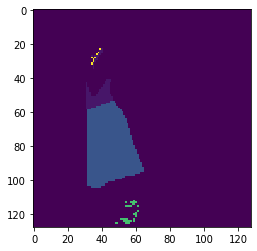

In [51]:
# test
g = ImgMask_sequencer(fash_train)
rv = g.__getitem__(1)
colorMap = get_colorMap(47)
mask = oneHot_to_mask(rv[1][0])
plt.imshow(mask)
#plt.imshow(rv[0][0])

### Prediction
Use model to create masks from images

In [41]:
def predict_on_train(fash_train, img_dir, model,num_predictions:int=1, im_height=im_height,im_width=im_width):
    
    # get basic info 
    classes = fash_train.class_ids
    num_classes = fash_train.num_classes
    colorMap = get_colorMap(num_classes)
    
    def get_pred():
        # get a random image from fash_train
        num_images = len(fash_train.image_info)
        rnd_idx = random.randint(0,num_images)
        entry = fash_train.image_info[rnd_idx]
        orig_shape = (entry['height'], entry['width'], 3)
        img = fash_train.load_image(rnd_idx)
        mask = fash_train.load_mask(rnd_idx)
        mask = oneHot_to_mask(mask[0])
        mask = colorize_mask(mask, colorMap)

        # make a prediction on the image
        pred_batch = cv2.resize(img, (im_height,im_width)).reshape(1,im_height,im_width,3)
        mask_pred = np.round(model.predict(pred_batch),0).astype(int)
        mask_pred = oneHot_to_mask(mask_pred[0])
        mask_pred = colorize_mask(mask_pred, colorMap)

        # resize the mask to match the original image
        mask_pred = (np.resize(mask_pred, orig_shape)*255).astype(int)
        
        return img, mask, mask_pred
    
    # plot
    fig, ax = plt.subplots(nrows=num_predictions, ncols=3, figsize=(15,5))
    
    for row in range(num_predictions):
        img, mask, mask_pred = get_pred()
          
        i=0
        ax[row][i].set_title("Original Image")
        ax[row][i].imshow(img)

        i=1
        ax[row][i].set_title("Ground Truth Mask")
        ax[row][i].imshow(mask)

        i=2
        ax[row][i].set_title("Predicted Mask")
        ax[row][i].imshow(mask_pred)
    
    return mask_pred

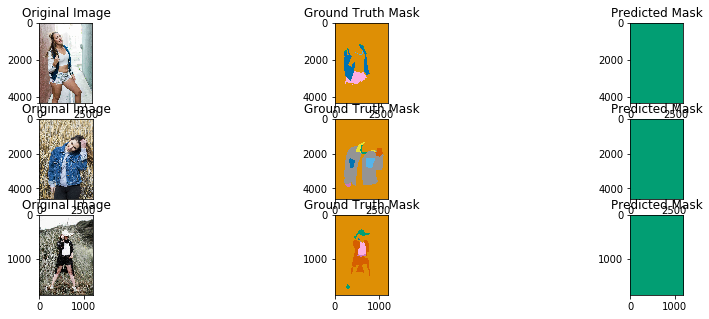

In [42]:
pred = predict_on_train(fash_train, img_dir, model, num_predictions=3)